In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, r2_score, mean_absolute_error, mean_squared_error, confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

# Лабораторная №3 - Проведение исследований с алгоритмом Дерево решений

## 1.Выбор начальных условий

In [16]:
pd.options.display.max_columns = None
data_classification = pd.read_csv('class_data/stackoverflow_full.csv').drop('Unnamed: 0', axis=1) #Выгрузка csv с данными классификации

files = ['FOOD-DATA-GROUP1.csv', 'FOOD-DATA-GROUP2.csv', 'FOOD-DATA-GROUP3.csv', 'FOOD-DATA-GROUP4.csv', 'FOOD-DATA-GROUP5.csv']
data_reg = pd.concat((pd.read_csv(f'reg_data/{f}') for f in files), ignore_index=True).drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1) #объединение и выгрузка сразу всех файлов с данными регрессии

Для оценки качества Классификации будем использовать такие же метрики как в прошлой работе: 
- Accuracy (Процент правильных предсказаний)
- F1-Score (важная метрика если классы несбалансированны)
- Confusion Matrix (Матрица которая покажет полную карту в работе модели)

Для оценки качества Регрессии будем использовать такие же базовые метрики как и в прошлой работе:

- RMSE (показывает типичный размер ошибки в исходных единицах) 
- MAE (устойчива к выбросам)
- R^2 (показывает общее качество модели)

## 2.Создание бейзлайна и оценка качества

Перед созданием и обучением модели, нам надо немного почистить и закодировать данные в датафрейме Классификации, тк модель не сможет работать с object признаками. Датафрейм регрессии уже готов для обучения модели.

In [21]:
def encoder_data(data: pd.DataFrame):
    onehot = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
    Ordinal = OrdinalEncoder()
    
    if 'HaveWorkedWith' in data.columns:
        tech_dummies = data['HaveWorkedWith'].str.get_dummies(sep=';')
        data = pd.concat([data, tech_dummies], axis=1)
        data = data.drop('HaveWorkedWith', axis=1)
    
    categorical_features = data.select_dtypes(include=['object']).columns
    for col in categorical_features:
        
        if data[col].nunique() == 2:
            col_encoded = onehot.fit_transform(data[[col]])
            col_df = pd.DataFrame(col_encoded, columns=onehot.get_feature_names_out([col]))
            data = pd.concat([data.drop(col, axis=1), col_df], axis=1)
            
        else:
            col_encoded = Ordinal.fit_transform(data[[col]])
            col_df = pd.DataFrame(col_encoded, columns=Ordinal.get_feature_names_out([col]))
            data = pd.concat([data.drop(col, axis=1), col_df], axis=1)
    return data

data_classification_encoded = encoder_data(data_classification)

После всей кодировки данных перейдём к обучению моделей. Разделим данные на тренировочные и тестовые для обучения и проверки метрик на данных которые модель ещё не видела и приступим к обучению

In [23]:
y_classification = data_classification_encoded['Employed']
x_classification = data_classification_encoded.drop('Employed', axis = 1)

y_reg = data_reg['Nutrition Density']
x_reg = data_reg.drop(['Nutrition Density','food'], axis=1)

X_train_classification, X_test_classification, y_train_classification, y_test_classification = train_test_split(x_classification, y_classification, test_size=0.33, 
                                                                                                                random_state=42) # разделение данных на тестовые и обучающие выборки

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(x_reg, y_reg, test_size=0.33, random_state=42)

Далее Создадим модели Дерева решений и обучим их

In [27]:
classification_model = DecisionTreeClassifier() #модель Дерева решений для Классификации
Reg_model = DecisionTreeRegressor() #Модель Дерева решений для Регрессии

classification_model_fit = classification_model.fit(X_train_classification, y_train_classification) # обучение модели Классификации
Reg_model_fit = Reg_model.fit(X_train_reg, y_train_reg) # Обучение модели Регрессии

classification_predict = classification_model_fit.predict(X_test_classification) # Предсказываем для дальнейшего просмотра метрик
reg_predict = Reg_model_fit.predict(X_test_reg)

После обучения моделей выведем все метрики и оценим качество работы

Метрики Дерева решений для классификации: 
Accuracy - 0.9979787980035474 
f1 - 0.998109640831758



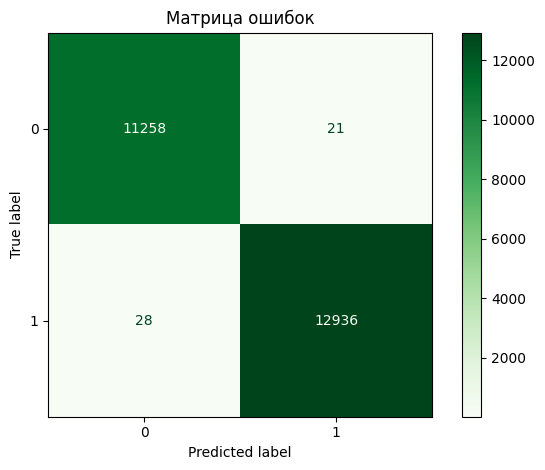

Метрики Дерева решений регрессии: 
MAE - 16.66487484197219 
R^2 - 0.9156960518200912
RMSE - 44.503062710212745



In [29]:
def metrics_class(true, predict):
    print(f'Метрики Дерева решений для классификации: \n'
          f'Accuracy - {accuracy_score(true, predict)} \n'
          f'f1 - {f1_score(true, predict)}\n')

    matrix = confusion_matrix(true, predict)
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
    disp.plot(cmap='Greens', values_format='d')
    plt.title('Матрица ошибок')
    plt.tight_layout()
    plt.show()

metrics_class(y_test_classification, classification_predict)

def metric_reg(true, predict):
        print(f'Метрики Дерева решений регрессии: \n'
          f'MAE - {mean_absolute_error(true, predict)} \n'
          f'R^2 - {r2_score(true, predict)}\n'
          f'RMSE - {np.sqrt(mean_squared_error(true, predict))}\n')
metric_reg(y_test_reg, reg_predict)

##### Метрики для бинарной классификации оказались следующими:
- Accuracy - 0.998 Очень высокий результат и очень подозрительный, либо утечка данных, либо наше дерево переобучилось (По стандарту в дереве глубина бесконечна)
- f1 - 099878 Так же очень подозрительный результат который потом надо будет проверить.
##### Метрики для регрессии оказались следующими:
- MAE - 16.6 означает, что средняя ошибка составляет 16.6 единицы, что является прекрасный результатом
- R² - 0.917 модель объясняет 91.7% дисперсии целевой переменной. Тоже очень хороший результат
- RMSE - 43.93 стандартное отклонение ошибок 43 единицы.

## 3.Улучшение бейзлайна

В связи с тем, что на базовом бейзлайне в Классификации наша модель показала крайне подозрительные ситуации, нам надо проверить, нет ли утечки данных целевой переменной, либо дерево так сильно переобучилось. В первой работе мы уже смотрели на Корреляцию признаков данных Классификации и ничего подозрительного не увидели, ComputerSkills была самой важной, но не настолько, чтобы повторять целевею переменную. Проверим какие признаки наша модель считает важными, если найдём там признак который будет выше 0.7 хотя бы, то удалим его как Утечка целевой переменной.

Так же не забудем:
- применим кросс-валидацию к моделям
- подберём к ней гиперпараметры через GridSreachCV.

Что мы делать не будем:
- удалять мультиколлинерность не будем, дерево никак не страдает от него в отличии от Линейных моделей
- нормализируем данные регрессии, применив StandartScaler, дерево работает с порядком, а не величинами, в этом нет нужды

In [39]:
# Какие признаки дерево считает важными
feature_importance = pd.DataFrame({
    'feature': X_train_classification.columns,
    'importance': classification_model_fit.feature_importances_
}).sort_values('importance', ascending=False)

print("Важность признаков:")
print(feature_importance.head(10))

# Если один признак имеет importance > 0.7 - это подозрительно
if feature_importance['importance'].max() > 0.7:
    top_feature = feature_importance.iloc[0]
    print(f"Подозрительный признак: {top_feature['feature']} (importance: {top_feature['importance']:.3f})")

Важность признаков:
                  feature  importance
4          ComputerSkills    0.344112
78                Node.js    0.085938
16                     C#    0.078407
13             Bash/Shell    0.074997
73   Microsoft SQL Server    0.067700
111            TypeScript    0.063217
119                jQuery    0.060672
59                   Java    0.059565
103                SQLite    0.059169
120                   npm    0.055078


В важности признаков нету ничего подозрительного, самый сильный признак по корреляции отвечает за 34% точности разделения данных, это высокий результат среди всех других признаков, но в этом нет ничего удивительного и подозрительного. Скорее всего связано это с тем, что большенство наших признаков это именно бинарные значения и они хорошо разделимы, как и все данные в целом в данном Датасете.

### Найдём гиперпараметры модели с кросс-валидацией

##### Параметры для Дерева решений:
- max_depth - Максимальная глубина дерева
- min_samples_split - Минимальное количества разделений для узла
- min_samples_leaf - Минимальное количество ячеек в листе (конечном узле)
- criterion - Критерий для измерения качества разделения
- max_features - Количество признаков для поиска лучшего разделения

In [44]:
tree_params_class = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy']
}

tree_params_reg = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['squared_error', 'absolute_error', 'friedman_mse']
}

model_class = DecisionTreeClassifier()
grid_class = GridSearchCV(estimator=model_class, param_grid=tree_params_class,cv=5) 

model_reg = DecisionTreeRegressor()
grid_reg = GridSearchCV(estimator=model_reg, param_grid=tree_params_reg, cv=5)

Tree_Class = grid_class.fit(X_train_classification, y_train_classification)
Tree_Reg = grid_reg.fit(X_train_reg, y_train_reg)

Метрики Дерева решений для классификации: 
Accuracy - 0.9667532896093718 
f1 - 0.968076679340938



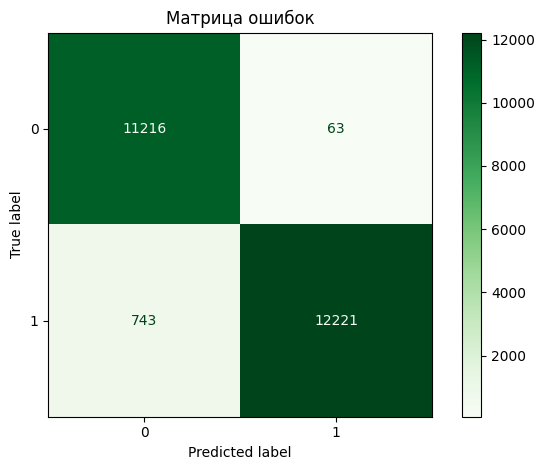

Метрики Дерева решений регрессии: 
MAE - 17.082010745891278 
R^2 - 0.9169409290002899
RMSE - 44.17326267026063



In [45]:
predict_class = Tree_Class.predict(X_test_classification)
predict_reg = Tree_Reg.predict(X_test_reg)

metrics_class(y_test_classification, predict_class)
metric_reg(y_test_reg, predict_reg)

Данные метрики уже выглядят более реалистично, особенно посмотрим на Классификацию. Мы ограничили глубину дерева и оно не переобучилось, выучив весь шум в данных, что очень хорошо. Такое дерево явно лучше работает и понимает концепцию всех Данных, нежели переобученное, что выучило весь шум в данных.

# 4.Имплементация алгоритма машинного обучения 

Создадим собственную модель дерева решений, будем использовать её как для Регрессии, так и для классификации. Сначала применим её для базового бейзлайна, а после напишем функцию для подбора гиперпараметров и улучшенный бейзлайн

In [46]:
class DecisionTree:
    def __init__(self, max_depth=5, min_samples_split=2, mode="classification"):
        """
        max_depth - максимальная глубина дерева
        min_samples_split - минимальное количество объектов для разбиения
        mode - "classification" или "regression"
        """
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.mode = mode
        self.tree = None

    class Node:
        def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
            self.feature = feature
            self.threshold = threshold
            self.left = left
            self.right = right
            self.value = value  # для листа

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y)
        self.tree = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        n_samples, n_features = X.shape
        if depth >= self.max_depth or n_samples < self.min_samples_split:
            return self.Node(value=self._leaf_value(y))

        best_feat, best_thresh, best_score = None, None, np.inf
        for feat in range(n_features):
            thresholds = np.unique(X[:, feat])
            for t in thresholds:
                left_mask = X[:, feat] <= t
                right_mask = X[:, feat] > t
                if left_mask.sum() == 0 or right_mask.sum() == 0:
                    continue
                y_left, y_right = y[left_mask], y[right_mask]
                score = self._impurity(y_left, y_right)
                if score < best_score:
                    best_feat, best_thresh, best_score = feat, t, score

        if best_feat is None:
            return self.Node(value=self._leaf_value(y))

        left_node = self._build_tree(X[X[:, best_feat] <= best_thresh], y[X[:, best_feat] <= best_thresh], depth+1)
        right_node = self._build_tree(X[X[:, best_feat] > best_thresh], y[X[:, best_feat] > best_thresh], depth+1)
        return self.Node(best_feat, best_thresh, left_node, right_node)

    def _impurity(self, y_left, y_right):
        if self.mode == "classification":
            return (len(y_left)*self._gini(y_left) + len(y_right)*self._gini(y_right)) / (len(y_left)+len(y_right))
        else:
            return (len(y_left)*self._variance(y_left) + len(y_right)*self._variance(y_right)) / (len(y_left)+len(y_right))

    def _gini(self, y):
        counts = np.bincount(y.astype(int))
        p = counts / counts.sum()
        return 1 - np.sum(p**2)

    def _variance(self, y):
        return np.var(y)

    def _leaf_value(self, y):
        if self.mode == "classification":
            return Counter(y).most_common(1)[0][0]
        else:
            return y.mean()

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        return np.array([self._predict_one(x, self.tree) for x in X])

    def _predict_one(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.threshold:
            return self._predict_one(x, node.left)
        else:
            return self._predict_one(x, node.right)


После написания собственного класса Дерева решений, обучим наши модели на данных и проверим метрики.

In [47]:
class_model = DecisionTree(mode="classification")
reg_model = DecisionTree(mode="Regression")

class_model.fit(X_train_classification, y_train_classification)
reg_model.fit(X_train_reg, y_train_reg)

Создали и обучили модели, теперь предскажем и проверим метрики.

Метрики Дерева решений для классификации: 
Accuracy - 0.8633832446479396 
f1 - 0.8753199819304321



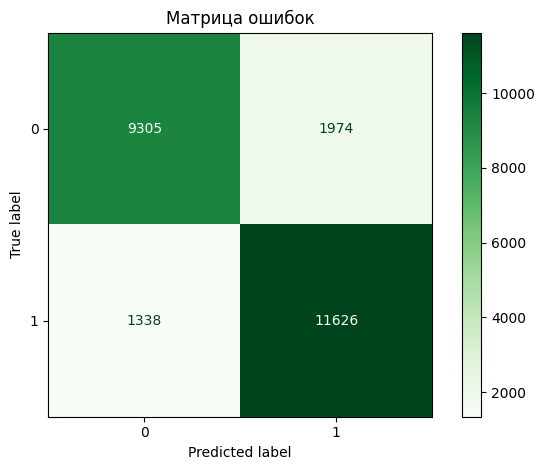

Метрики Дерева решений регрессии: 
MAE - 38.35801518109939 
R^2 - 0.3551312330540368
RMSE - 123.08400372256493



In [49]:
pred_class = class_model.predict(X_test_classification)
pred_reg = reg_model.predict(X_test_reg)

metrics_class(y_test_classification, pred_class)
metric_reg(y_test_reg, pred_reg)

Метрики Дерева решений для классификации:
- Accuracy - 0.86 - На базовом бейзлайне модель из sklearn сильно переобучилась, тут же метрики показывают себя прекрасно
- f1 - 0.87 Идентичная ситуация как и с Accuracy

Метрики Дерева решений для Регрессии:
- MAE - 38.35 Результат куда хуже чем модели sklearn
- R^2 - 0.35 Всего 35, довольно слабый результат
- RMSE - 123.08 Ситуация схожая с прошлыми метриками

Теперь подберём гиперпараметры для модели с приминением Кросс-валидации, а далее проверим метрики

In [52]:
print(f'Лучшие параметры для задачи регрессии:{grid_class.best_params_}')
print(f'Лучшие параметры для задачи Классификации:{grid_reg.best_params_}')

Лучшие параметры для задачи регрессии:{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
Лучшие параметры для задачи Классификации:{'criterion': 'absolute_error', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [54]:
class_model_second = DecisionTree(mode="classification", max_depth=grid_class.best_params_['max_depth'], min_samples_split=grid_class.best_params_['min_samples_split'])
class_model_second.fit(X_train_classification, y_train_classification)

Находим наилучшие параметры для классификации, создаём модель и обучаем её

In [56]:
reg_model_second = DecisionTree(mode="Regression", max_depth=grid_reg.best_params_['max_depth'], min_samples_split=grid_reg.best_params_['min_samples_split'])
reg_model_second.fit(X_train_reg, y_train_reg)

Находим наилучшие параметры для регрессии, создаём модель и обучаем её

Метрики Дерева решений для классификации: 
Accuracy - 0.9665470445076929 
f1 - 0.9678850037619292



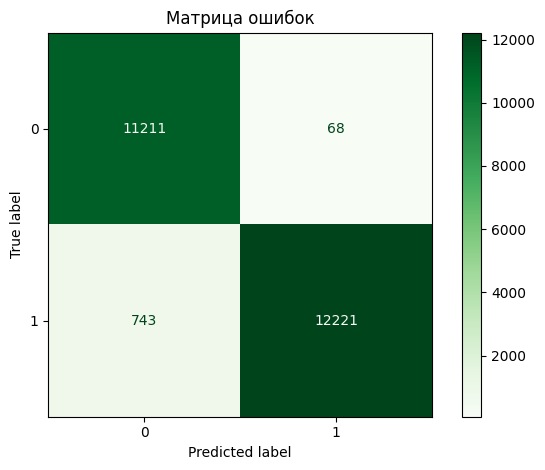

Метрики Дерева решений регрессии: 
MAE - 23.510745203339184 
R^2 - 0.41388950929088264
RMSE - 117.34259560275325



In [58]:
predict_class = class_model_second.predict(X_test_classification)
predict_reg = reg_model_second.predict(X_test_reg)

metrics_class(y_test_classification, predict_class)
metric_reg(y_test_reg, predict_reg)

Метрики для нашего Дерева решений классификация в новом бейзлайне:
- Accuracy - 0.96 
- f1 - 0.967
##### Метрики сильно поднялись в сравнеии с прошлым безлайном и переобучения тут незаметно, это прекрасный результат для нашего дерева решений.

Метрики для нашего Дерева решений для регрессии в новом бейзлайне:
- MAE - 23.51 Тут метрики так же не особо сильно отличаются
- R^2 - 0.41 
- RMSE - 117.34
##### Метрики довольно слабые, данный безлайн показал себя лучше прошлого, но наша модель в целом показала себя куда хуже чем модель из sklearn

# Вывод по проделанной работе

В ходе лабораторной работы была проведена работа с такой моделью ак Дерево решений, очень простая модель, которая ожидаемо хорошо справилась с задачей классификацией и не очень с задачей Регрессии. Данная модель очень любит переобучаться, поэтому с ней нужно было аккуратнее, в задаче с Классификацией 70 тысяч строк данных и этого достаточно, чтобы модель переобучилась и задевала все шумы в данных. Большая часть зависит от глубины дерева, в данном случае идеальной была бы глубина около 6-7. В нашей работе лучше всего себя показали Модели второго бейзлайна, в обоих случаях с частотой с 0.96.